In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

import xgboost as xgb

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline

## Tree-Based Methods

### Download the APS Failure data
Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
#  positive class - component failures for a specific component of the APS system
#  negative class - trucks with failures for components not related to the APS

test_df = pd.read_csv("data/aps_failure_test_set.csv", skiprows=20, na_values=["na"])
train_df = pd.read_csv("data/aps_failure_training_set.csv", skiprows=20, na_values=["na"])

cols = train_df.columns.tolist() # all column names
x_vars = cols[1:] # all x vars (excluded "class")

print(train_df)

      class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
59995   neg  153002     NaN  6.640000e+02   186.0     0.0     0.0     0.0   
59996   neg    2286     NaN  2.130707e+09   224.0     0.0     0.0     0.0   
59997   neg     112     0.0  2.130706e+09    18.0     0.0     0.0     0.0   
59998   neg   80292     NaN  2.130706e+09   494.0     0.0     0.0     0.0   
59999   neg   40222     NaN  6.980000e+02   628.0     0.0     0.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003     ee_004     ee_005  \
0 

### Data Preparation

#### Research what types of techniques are usually used
This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [3]:
# col names were anonymized by the original dataset creators to protect proprietary sensor/process information
# each col likely corresponds to a sensor measurement, calculated diagnostic feature, or aggregated time series reading from an air pressure system
# explore missing data cols in the train and test data

# check for missing data
train_nan = train_df.isna().mean() * 100
missing_train = train_nan[train_nan > 0].sort_values(ascending=False)
print("Missing from Training Data")
print(missing_train)

test_nan = test_df.isna().mean() * 100
missing_test = test_nan[test_nan > 0].sort_values(ascending=False)
print("Missing from Training Data")
print(missing_test)

# get a list of col names with missing data
missing_cols_train = missing_train.index.tolist()
missing_cols_test = missing_test.index.tolist()
print(missing_cols_train)

Missing from Training Data
br_000    82.106667
bq_000    81.203333
bp_000    79.566667
bo_000    77.221667
ab_000    77.215000
            ...    
by_000     0.788333
ci_000     0.563333
cj_000     0.563333
ck_000     0.563333
bt_000     0.278333
Length: 169, dtype: float64
Missing from Training Data
br_000    82.05625
bq_000    81.13125
bp_000    79.50625
bo_000    77.35000
ab_000    77.26875
            ...   
by_000     0.66875
ck_000     0.53750
cj_000     0.53750
ci_000     0.53750
bt_000     0.17500
Length: 169, dtype: float64
['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000', 'bl_000', 'bk_000', 'ch_000', 'co_000', 'cf_000', 'cg_000', 'ad_000', 'db_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'dc_000', 'ec_00', 'cm_000', 'ed_000', 'cl_000', 'ak_000', 'ca_000', 'dm_000', 'dh_000', 'dg_000', 'df_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000', 'ds_000', 'bd_000', 'dt_000', 'du_000', '

In [4]:
# observe suspected grouped / potentially time series data
# id'ed by inspecting missing_cols
ag = ['ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009']
ay = ['ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009']
az = ['az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009']
ba = ['ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009']
cn = ['cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009']
cs = ['cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006', 'cs_007', 'cs_008', 'cs_009']
ee = ['ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009']

grouped_cols = [ag, ay, az, ba, cn, cs, ee]
all_grouped_cols = ag + ay + az + ba + cn + cs + ee

def inspect_group(df, group_vars):
    print(df[group_vars])

    nan = df[group_vars].isna().mean() * 100
    missing_data = nan[nan > 0].sort_values(ascending=False)

    print("Missing Data:")
    print(missing_data)

# check for groups with missing data
for cols in grouped_cols:
    fully_missing_rows = train_df[cols].isna().all(axis=1).sum()
    print(f"{cols[0]} group: {fully_missing_rows} fully missing rows")

ag_000 group: 671 fully missing rows
ay_000 group: 671 fully missing rows
az_000 group: 671 fully missing rows
ba_000 group: 688 fully missing rows
cn_000 group: 687 fully missing rows
cs_000 group: 669 fully missing rows
ee_000 group: 671 fully missing rows


In [ ]:
# mean
# Numerical data with a normal distribution (or approximately normal)
# Continuous variables where the mean is a representative central tendency

# median
# Numerical data with a skewed distribution
# Continuous variables where the median is a more robust central tendency

# mode
# Categorical data where the most frequent category is a meaningful representation of missing values
# Ordinal data where the mode can be used as a central tendency

def get_imputation_strategy(df, missing_cols):
    imputation_data = []

    for col in missing_cols:
        col_data = df[col].dropna()
        col_outputs = col_data.nunique()

        if col_outputs == 2:
            description = "binary data"
            strategy = "mode"
        elif col_outputs <= 6:
            description = "low cardinality"
            strategy = "mode"
        # assess skew on remaining data
        # 0 is normal distrbibution, abs(0.5 to 1) is moderate skew, above abs(1) is high skewness
        else:
            col_skew = skew(col_data)
            if abs(col_skew) > 1:
                description = "numeric skewed data"
                strategy = "median"
            else:
                description = "numeric normally distrbuted data"
                strategy = "mean"

        imputation_data.append({
            'column': col,
            'description': description,
            'strategy': strategy
        })

    imputation_df = pd.DataFrame(imputation_data)

    # make list of vars for each plan 
    mean_vars = imputation_df.loc[imputation_df['strategy'] == 'mean', 'column'].tolist()
    median_vars = imputation_df.loc[imputation_df['strategy'] == 'median', 'column'].tolist()
    mode_vars = imputation_df.loc[imputation_df['strategy'] == 'mode', 'column'].tolist()

    return mean_vars, median_vars, mode_vars

mean_vars_train, median_vars_train, mode_vars_train = get_imputation_strategy(train_df, missing_cols_train)
mean_vars_test, median_vars_test, mode_vars_test = get_imputation_strategy(test_df, missing_cols_test)


In [6]:
# impute grouped data using median from the row
# row-wise imputation keeps the internal pattern between the columns intact for each observation
# if row-wise imputation fails because all data in the row is empty, use column data for that var

for cols in grouped_cols:
    row_medians_train = train_df[cols].median(axis=1)
    row_medians_test = test_df[cols].median(axis=1)

    for col in cols:
        train_df[col] = train_df[col].fillna(row_medians_train)
        test_df[col] = test_df[col].fillna(row_medians_test)

    for col in cols:
        train_df[col] = train_df[col].fillna(train_df[col].median())
        test_df[col] = test_df[col].fillna(test_df[col].median())

In [7]:
def imputation(mode_vars, mean_vars, median_vars, df):

    # impute mode vars
    for col in mode_vars:
        mode_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode_val)

    # impute mean vars
    for col in mean_vars:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)

    # impute median vars (excluding the grouped vars)
    for col in median_vars:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    
    return df

median_vars_ungrouped_train = [col for col in median_vars_train if col not in all_grouped_cols]
median_vars_ungrouped_test = [col for col in median_vars_test if col not in all_grouped_cols]

imputation(mode_vars_train, mean_vars_train, median_vars_ungrouped_train, train_df)
imputation(mode_vars_test, mean_vars_test, median_vars_ungrouped_test, test_df)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,0.0,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,0.0,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,0.0,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,0.0,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,0.0,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [8]:
# re-check for missing data
train_nan = train_df.isna().mean() * 100
missing_train = train_nan[train_nan > 0].sort_values(ascending=False)

test_nan = test_df.isna().mean() * 100
missing_test = test_nan[test_nan > 0].sort_values(ascending=False)

print("Remaining Missing in Training Data:")
print(missing_train)

print("Remaining Missing in Test Data:")
print(missing_test)

Remaining Missing in Training Data:
Series([], dtype: float64)
Remaining Missing in Test Data:
Series([], dtype: float64)


#### Calculate the coefficient of variation
For each of the 170 features, calculate the coefficient of variation CV = s / m, where s is sample standard deviation and m is sample mean.

In [ ]:
# std is sensitive to the scale of the data, CV is unitless (allows direct comparison of variability)
# higher absolute vals represent greater degree of relative variability - can be useful for feature selection
# features that have low variabliltiy (ex. 1,1,1,1, etc) have little to no predictive power

def get_coeff_of_variation(df):
    feat_cvs = []
    for feature in x_vars:
        feat_s = df[feature].std()
        feat_m = df[feature].mean()

        feat_cv = feat_s / feat_m
        feat_cvs.append([feature, feat_cv, abs(feat_cv)])
    
    cv_df = pd.DataFrame(feat_cvs, columns=["feature", "CV", "Absolute CV"]) # used source 4
    sorted_cv_df = cv_df.sort_values(by='Absolute CV', ascending=False).reset_index(drop=True)

    return sorted_cv_df

cv_train_df = get_coeff_of_variation(train_df)
print(cv_train_df[:13])

cv_test_df = get_coeff_of_variation(test_df)
print(cv_test_df[:13])


   feature          CV  Absolute CV
0   cf_000  244.887517   244.887517
1   co_000  244.507385   244.507385
2   ad_000  244.322816   244.322816
3   cs_009  237.930554   237.930554
4   dh_000  123.216097   123.216097
5   dj_000  117.494225   117.494225
6   ag_000   92.917755    92.917755
7   as_000   87.332500    87.332500
8   ay_009   84.733735    84.733735
9   ak_000   80.424975    80.424975
10  az_009   77.838544    77.838544
11  ch_000   77.453857    77.453857
12  au_000   68.882751    68.882751
   feature          CV  Absolute CV
0   cs_009  126.148002   126.148002
1   ak_000  101.298458   101.298458
2   au_000   85.403843    85.403843
3   as_000   83.210811    83.210811
4   df_000   78.103163    78.103163
5   ch_000   73.025110    73.025110
6   cs_008   63.173402    63.173402
7   eg_000   60.545241    60.545241
8   az_009   60.394973    60.394973
9   dj_000   55.573957    55.573957
10  ag_000   53.725095    53.725095
11  ef_000   53.225724    53.225724
12  dk_000   52.213035    52

#### Plot a correlation matrix

Correlation Matrix for Train Data


<Figure size 1600x1100 with 0 Axes>

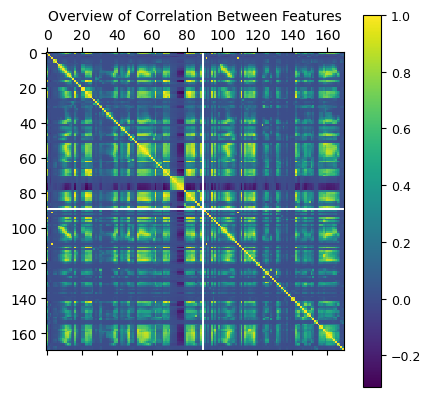

Correlation Matrix for Test Data


<Figure size 1600x1100 with 0 Axes>

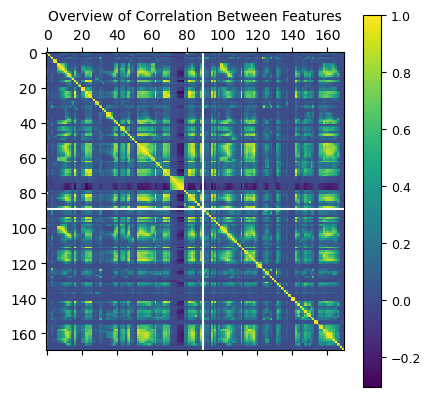

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.011041,-0.025357,0.022447,0.013345,0.015582,0.019828,0.049629,0.158411,0.219719,...,0.239420,0.249283,0.246342,0.259854,0.273647,0.240671,0.140520,0.067185,0.000169,0.000174
ab_000,0.011041,1.000000,-0.004366,0.035207,0.010820,0.052404,-0.000595,0.008424,0.031528,0.044516,...,0.003304,-0.000006,-0.002739,0.046218,0.018265,0.022662,-0.031623,-0.021751,0.022641,0.005583
ac_000,-0.025357,-0.004366,1.000000,0.064610,-0.002913,-0.011356,0.000514,-0.008838,-0.023911,-0.045875,...,-0.049920,-0.044655,-0.045202,-0.047654,-0.049779,-0.049903,-0.008300,0.006252,-0.006069,0.021126
ad_000,0.022447,0.035207,0.064610,1.000000,0.015897,0.030382,0.002610,0.007536,0.022153,0.039423,...,0.123505,0.085894,0.058016,0.046371,0.054745,0.025006,0.023129,0.023249,0.008716,0.004186
ae_000,0.013345,0.010820,-0.002913,0.015897,1.000000,0.876941,-0.000990,-0.001223,-0.002757,0.008146,...,0.009013,0.017816,0.006316,0.015455,0.084463,0.027841,-0.009938,-0.008395,0.015505,0.004265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.240671,0.022662,-0.049903,0.025006,0.027841,0.022108,0.104812,0.126140,0.197150,0.411069,...,0.399629,0.384471,0.356941,0.385866,0.541360,1.000000,0.239642,0.069784,-0.000616,-0.002275
ee_008,0.140520,-0.031623,-0.008300,0.023129,-0.009938,-0.012506,0.009182,0.006703,0.008358,0.019628,...,0.411622,0.441134,0.417953,0.358739,0.343636,0.239642,1.000000,0.635542,-0.004821,-0.001856
ee_009,0.067185,-0.021751,0.006252,0.023249,-0.008395,-0.009455,-0.000578,-0.003324,-0.008732,-0.015593,...,0.213666,0.225511,0.209282,0.163821,0.143421,0.069784,0.635542,1.000000,-0.002934,-0.001782
ef_000,0.000169,0.022641,-0.006069,0.008716,0.015505,0.015463,-0.000350,-0.000040,0.000815,0.000996,...,-0.003737,-0.004032,-0.004707,-0.001794,0.001668,-0.000616,-0.004821,-0.002934,1.000000,0.090955


In [10]:
# correlation matrix of all features
def get_correlation_matrix(df):
    correlation_matrix_all_feats = df.corr()

    # vague overview visualization of correlation between features
    # as we can see, lots of teal and blue on our graph (correlation of 0.5 to -0.5) w/ some yellow and purple
    plt.figure(figsize=(16,11))
    plt.matshow(df.corr())
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=9)
    plt.title('Overview of Correlation Between Features', fontsize=10);
    plt.show()

    return correlation_matrix_all_feats

print("Correlation Matrix for Train Data")
get_correlation_matrix(train_df[x_vars])

print("Correlation Matrix for Test Data")
get_correlation_matrix(test_df[x_vars])

#### Data Exploration

***Significance of √170 features with highest CV** The coefficient of variation is a relative measure of variability that indicates the size of a standard deviation in relation to its mean. Standard deviation is sensitive to the scale of the data, but because CV is unitless, it allows us to make a direct comparison of variability between all features. From the scatterplots, we can see that the plots are very spread out and diverse, with lots of points throughout the plot. This is a good thing because it means that these features have more predictive power when creating a model. When you take the absolute value of a CV, features with a higher value represent greater degree of relative variability, which can be useful for feature selection. Features that have low variablility (ex. 1,1,1,1,...), have little to no predictive power because it doesn't give our model any helpful insight.

Top Feats: ['cf_000', 'co_000', 'ad_000', 'cs_009', 'dh_000', 'dj_000', 'ag_000', 'as_000', 'ay_009', 'ak_000', 'az_009', 'ch_000', 'au_000']


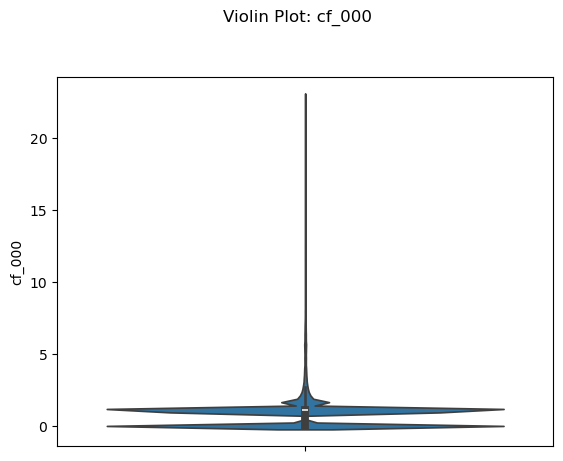

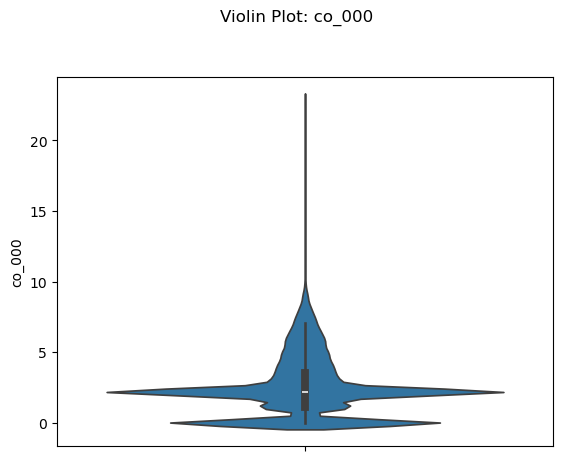

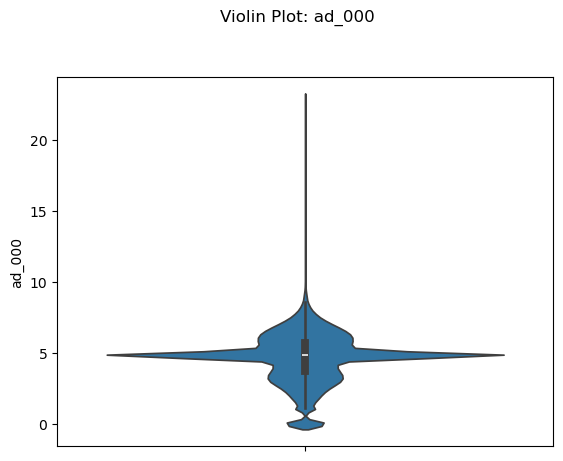

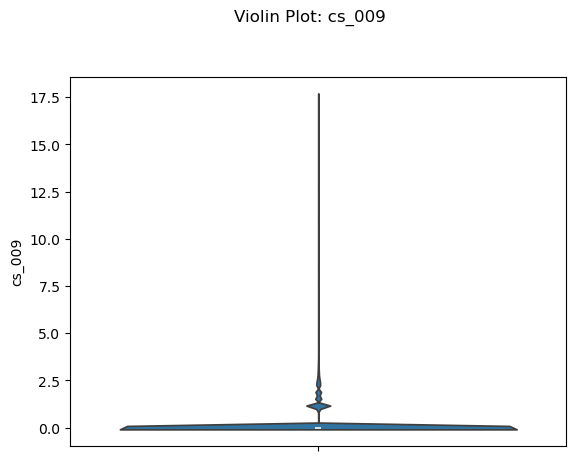

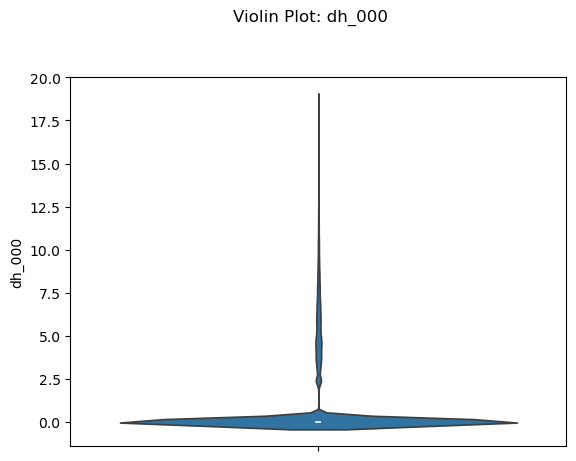

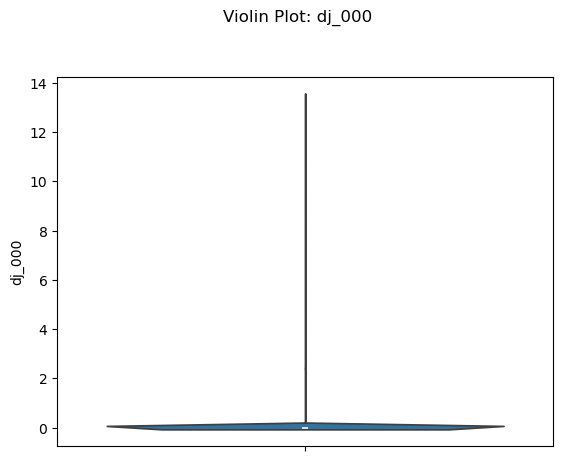

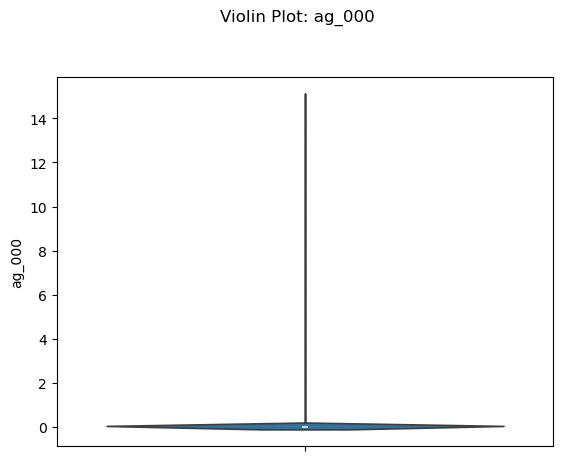

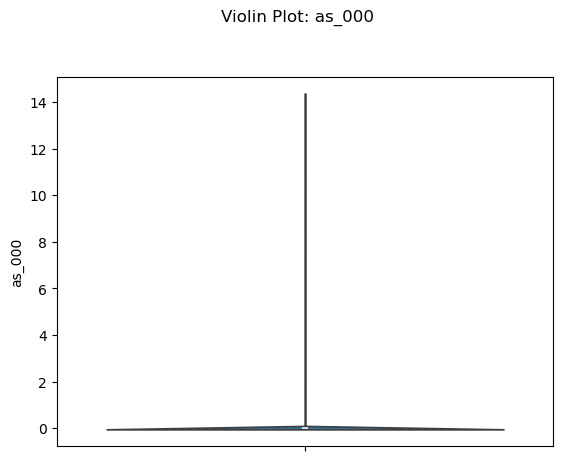

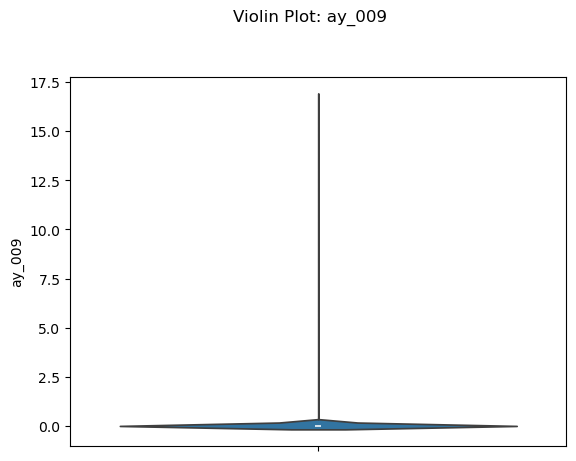

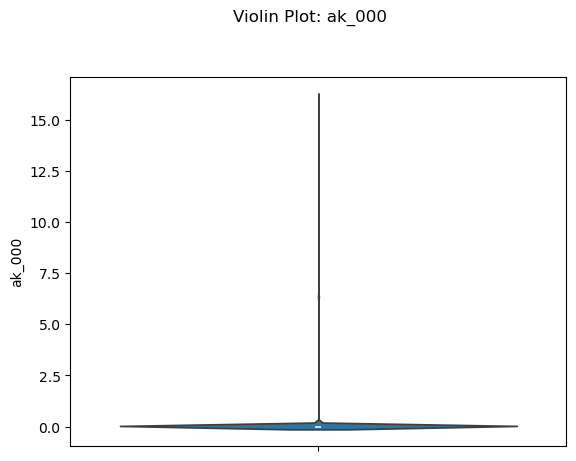

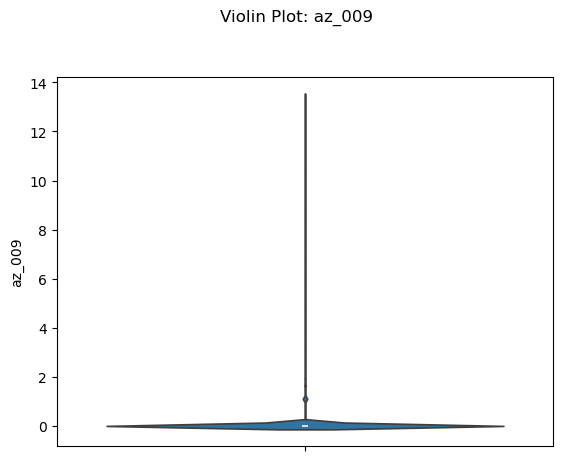

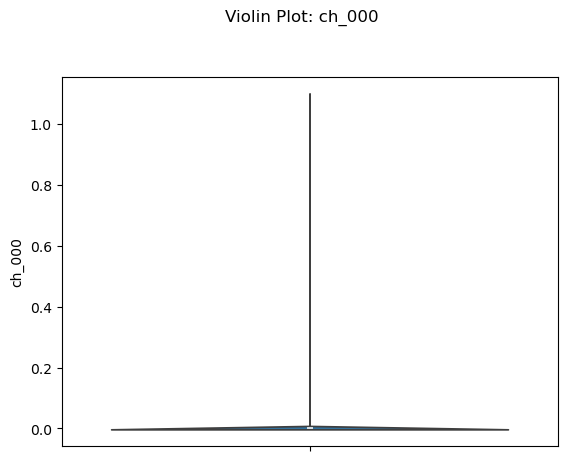

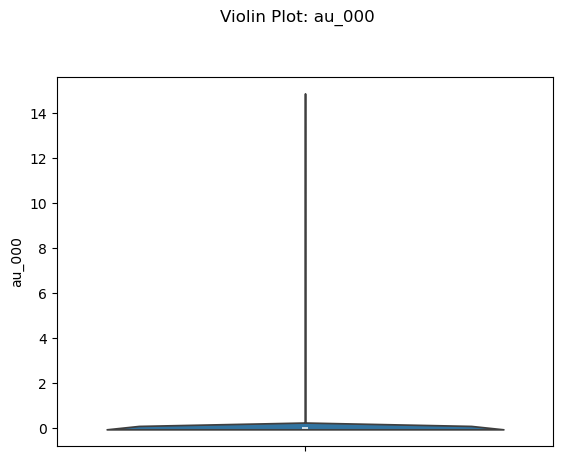

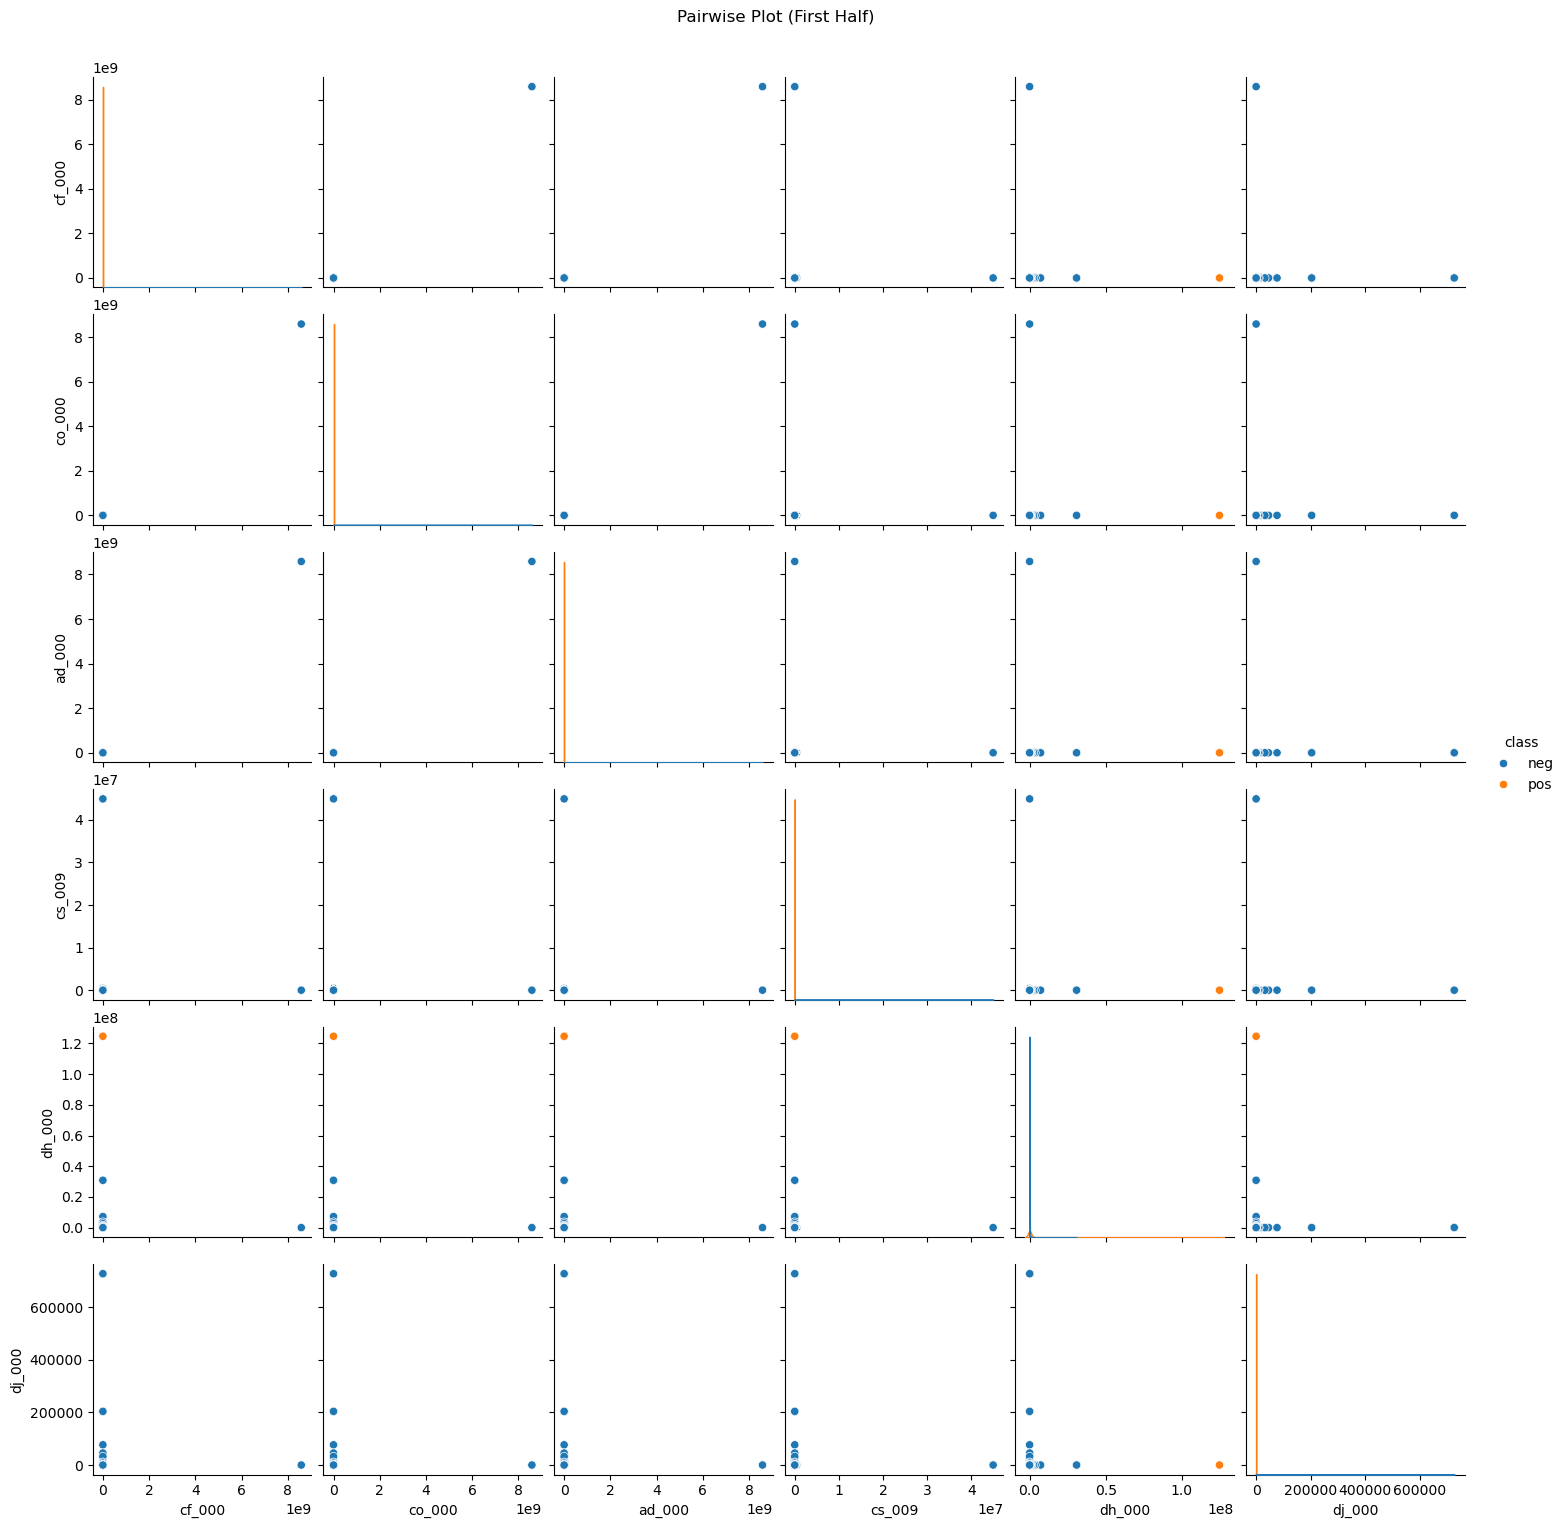

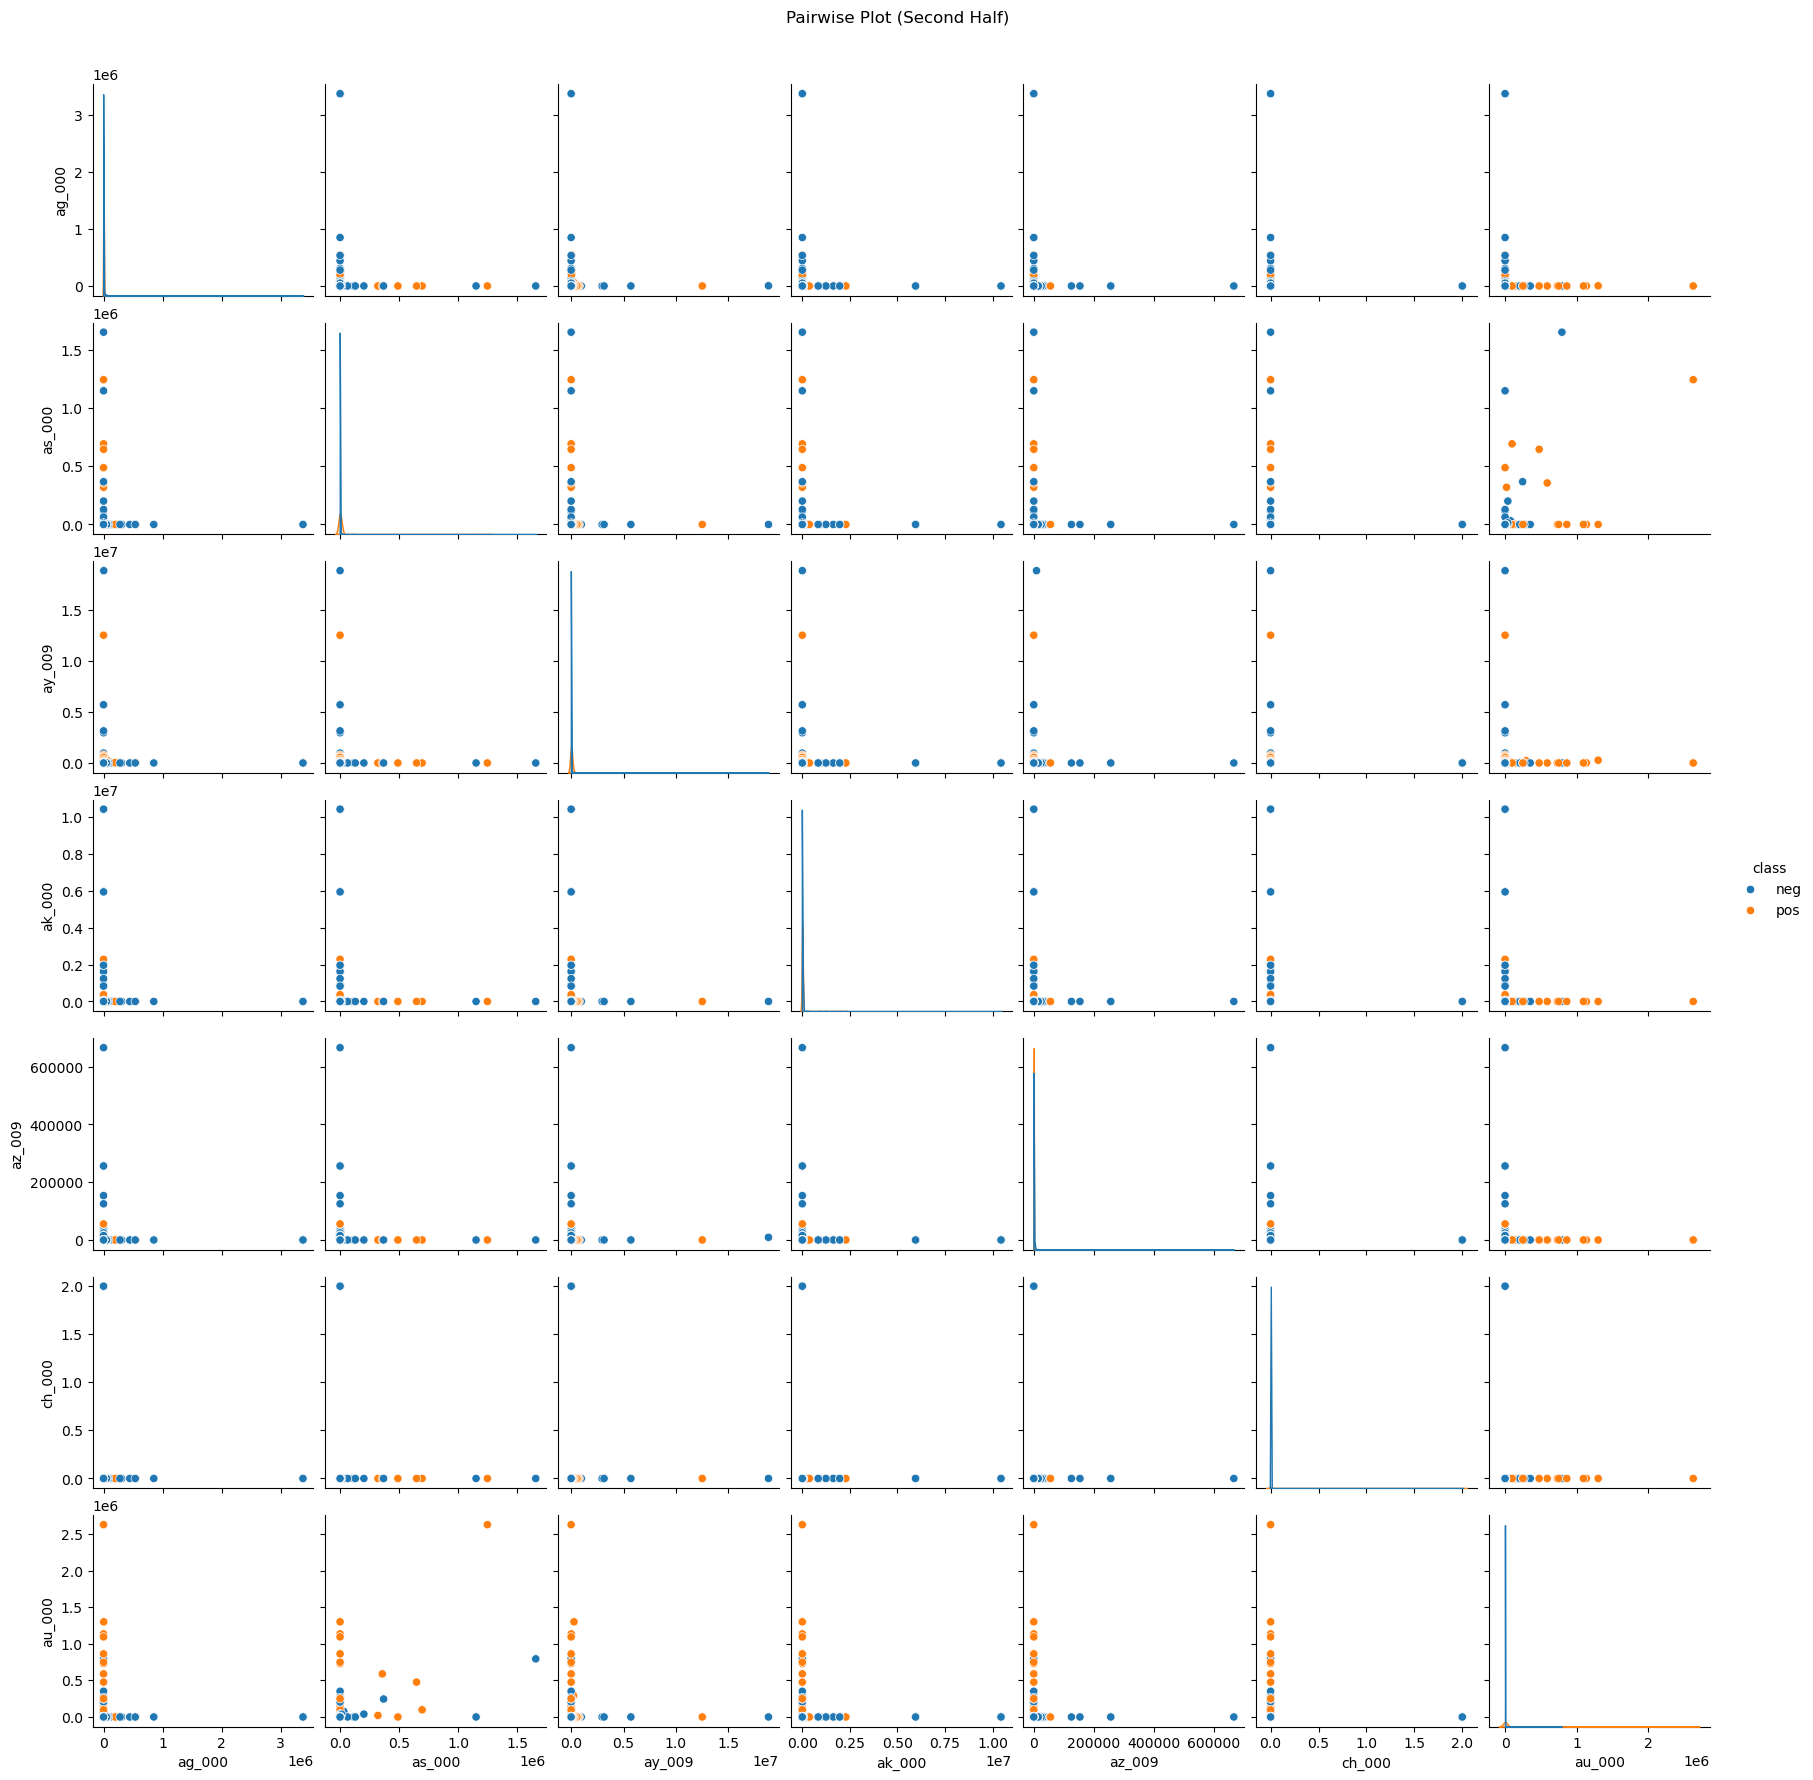

None


In [11]:
# make scatterplots for top features
def top_feat_pairplots(df):
    cv_df = get_coeff_of_variation(df)

    # get feats with the highest CV
    num_feats = int(np.sqrt(170))
    top_feats = cv_df[:num_feats]["feature"].to_list()
    print(f"Top Feats: {top_feats}")

    # top feats + independent variable df
    top_feats_cols = top_feats + ["class"]
    top_feats_df = df[top_feats_cols]

    # make violinplot of all top features
    for feat in top_feats:
        sns.violinplot(y=np.log1p(top_feats_df[feat]))
        plt.suptitle(f"Violin Plot: {feat}", y=1.02)
        plt.show()

    # Create pairplots by splitting list of top features into two halves for better visibility
    midpoint = len(top_feats) // 2
    first_split = top_feats[:midpoint] + ["class"]
    second_split = top_feats[midpoint:] + ["class"]

    sns.pairplot(df[first_split], hue="class")
    plt.suptitle("Pairwise Plot (First Half)", y=1.02)
    plt.show()

    sns.pairplot(df[second_split], hue="class")
    plt.suptitle("Pairwise Plot (Second Half)", y=1.02)
    plt.show()


print(top_feat_pairplots(train_df))

**Is this data set imbalanced?** Yes. In the test data, we have 15,625 negative cases and 375 positive cases. In the train data, there are 59,000 negative cases and 1,000 positive cases. This means that for every 1 positive case, there are about 41.67 negative cases in the test data and 59 negative cases in the train data.

In [12]:
print('\033[91m' + "Test Class Values" + '\033[0m')
test_counts = test_df['class'].value_counts()
test_ratio = round(test_counts["neg"] / test_counts["pos"], 2)
print(test_counts)
print(test_ratio)

print('\033[91m' + "Train Class Values" + '\033[0m')
train_counts = train_df['class'].value_counts()
train_ratio = round(train_counts["neg"] / train_counts["pos"], 2)
print(train_counts)
print(train_ratio)


Test Class Values
class
neg    15625
pos      375
Name: count, dtype: int64
41.67
Train Class Values
class
neg    59000
pos     1000
Name: count, dtype: int64
59.0


### Train a random forest and report the confusion matrix, ROC, AUC, and misclassification for training and test sets

In [13]:
# split x and y vars from train and test data
# Replace with your actual target column name

def split_data(train_data_df, test_data_df):
    y_train = train_data_df['class'] 
    X_train = train_data_df.drop(columns=['class'])

    y_test = test_data_df['class']
    X_test = test_data_df.drop(columns=['class'])

    return X_train, y_train, X_test, y_test

model_assessment = [["Model Summary", 
                     "Train Accuracy",
                     "Train Error Rate", 
                     "Test Accuracy",
                     "Test Error Rate",
                     "Out of Bag Error Estimate"
                    ]]

assessment_cols = ["Model Summary", "Train Accuracy", "Train Error Rate", "Test Accuracy", "Test Error Rate", "Out of Bag Error Estimate"]

Train Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15609    16]
 [  109   266]]


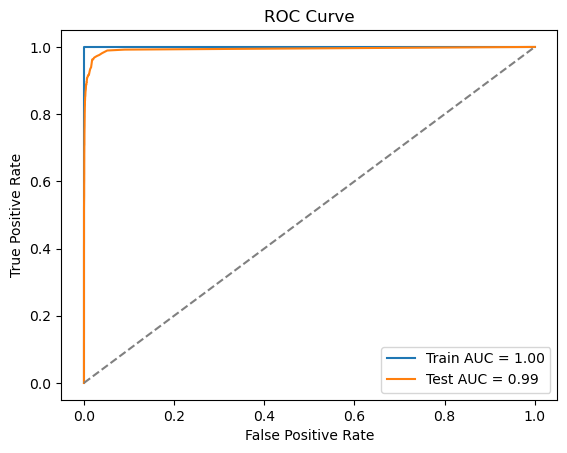

                Model Summary  Train Accuracy  Train Error Rate  \
0  Random Forest - Unbalanced        0.999983          0.000017   

   Test Accuracy  Test Error Rate  Out of Bag Error Estimate  
0       0.992188         0.007812                   0.006167  


In [ ]:
# NOT compensating for class imbalance in the data set
# Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them
# Calculate Out of Bag error estimate for your random forset and compare it to the test error

def assess_model(model, model_summary, oob, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)

    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    assessment = [[model_summary, 
            train_accuracy,
            train_error,
            test_accuracy,
            test_error
            ]]
        
    assessment_df = pd.DataFrame(assessment, columns=["Model Summary", "Train Accuracy", "Train Error Rate", "Test Accuracy", "Test Error Rate"])

    # use oob for random forest models
    if oob:
        oob_error = 1 - model.oob_score_
        assessment_df["Out of Bag Error Estimate"] = oob_error

    return assessment_df

def random_forest(model_summary, train_df, test_df):
    # prep data by splitting x and y vars, binarize
    X_train, y_train, X_test, y_test = split_data(train_df, test_df)
    y_train = y_train.map({'neg': 0, 'pos': 1})
    y_test = y_test.map({'neg': 0, 'pos': 1})

    # define and train model
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=13,
        oob_score=True,
        n_jobs=-1 # uses all processors to speed up model processing
    )

    rf.fit(X_train, y_train)

    # assess model
    asessment_df = assess_model(rf, model_summary, True, X_train, y_train, X_test, y_test)
    print(asessment_df)
    return asessment_df


rf_unbalanced = random_forest("Random Forest - Unbalanced", train_df, test_df)

### Managing class imbalance in random forest

I tried two methods of addressing the imbalanced data for random forests. The first method was setting the class_weight parameter to assign weights to the classes in the data in SKLearn. This method assigns higher weight to the minority class so that model is forced to pay more attention to the minority class during training. I chose to set class_weight to 'balanced_subsample', which applies weights individually to each trees bootstrap sample to reduce overfitting.  The second method was using BalancedRandomForestClassifier from Imbalanced Learn. This method resamples data for each tree, randomly under-sampling the majority class so that each tree uses a balanced dataset. The trees are then trained on equal numbers of majority and minority class samples.<br>

As we can see from our model assessment below, the train and test error for the Imbalanced-Learn model are very similar. This means that it is performing well to new, unseen data and is less susceptible to overfitting, which is why I would consider it the better model.<br>


Model Summary, Train Accuracy, Train Error Rate, Test Accuracy, Test Error Rate, Out of Bag Error Estimate <br>
Random Forest - Unbalanced, 0.999983, 0.000017, 0.992188, 0.007812, 0.006167<br>
Random Forest - Balanced Subsample, 1.000000, 0.000000, 0.989850, 0.010150, 0.013687<br>
Random Forest - Imbalanced-Learn BRF, 0.952625, 0.047375, 0.948633, 0.051367, 0.030813<br>

Train Confusion Matrix:
[[59000     0]
 [    2   998]]

Test Confusion Matrix:
[[15612    13]
 [  159   216]]


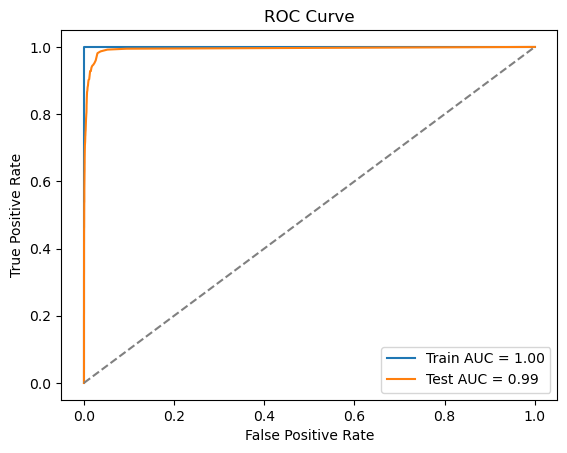

                        Model Summary  Train Accuracy  Train Error Rate  \
0  Random Forest - Balanced Subsample        0.999967          0.000033   

   Test Accuracy  Test Error Rate  Out of Bag Error Estimate  
0        0.98925          0.01075                     0.0079  


/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:887: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Train Confusion Matrix:
[[56216  2784]
 [   10   990]]

Test Confusion Matrix:
[[14910   715]
 [    8   367]]


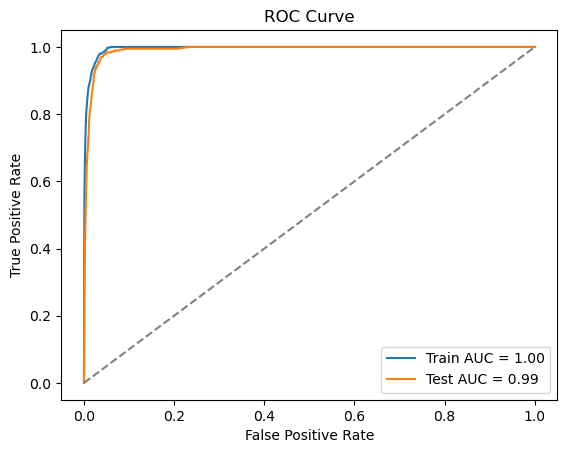

                          Model Summary  Train Accuracy  Train Error Rate  \
0  Random Forest - Imbalanced-Learn BRF        0.953433          0.046567   

   Test Accuracy  Test Error Rate  Out of Bag Error Estimate  
0       0.954812         0.045188                    0.02955  


In [ ]:
# class_weight parameter in Scikit-learn used to assign weights to the classes in the data
# assign higher weight to the minority class so that model is forced to pay more attention to the minority class during training
# SKLearn imbalanced data management - 'balanaced' automatically assigns weight to neg / pos classes
# 'balanced_subsample' applies weights individually to each trees bootstrap sample to reduce overfitting
def random_forest_balanced_subsample(model_summary, train_df, test_df):
    # prep data by splitting x and y vars, binarize
    X_train, y_train, X_test, y_test = split_data(train_df, test_df)
    y_train = y_train.map({'neg': 0, 'pos': 1})
    y_test = y_test.map({'neg': 0, 'pos': 1})
    
    rf_balanced = RandomForestClassifier(
        n_estimators=100,
        random_state=13,
        oob_score=True,
        class_weight='balanced_subsample',
        n_jobs=-1
    )

    rf_balanced.fit(X_train, y_train)

    # assess model
    asessment_df = assess_model(rf_balanced, model_summary, True, X_train, y_train, X_test, y_test)
    print(asessment_df)
    return asessment_df

# used source 9
# BalancedRandomForestClassifier is another approach to managing unbalanced data in RF
# resamples data for each tree — randomly under-samples the majority class so that each tree uses a balanced dataset
# trees trained on equal numbers of majority and minority class samples
def random_forest_imbalanced_learn(model_summary, train_df, test_df):
    # prep data by splitting x and y vars, binarize
    X_train, y_train, X_test, y_test = split_data(train_df, test_df)
    y_train = y_train.map({'neg': 0, 'pos': 1})
    y_test = y_test.map({'neg': 0, 'pos': 1})

    brf = BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=13,
        n_jobs=-1,
        oob_score=True,
        sampling_strategy='all',
        replacement=True,
        bootstrap=True
    )
    brf.fit(X_train, y_train)

    # assess model
    asessment_df = assess_model(brf, model_summary, True, X_train, y_train, X_test, y_test)
    print(asessment_df)
    return asessment_df

rf_balanced_subsample = random_forest_balanced_subsample("Random Forest - Balanced Subsample", train_df, test_df)
rf_imbalanced_learn = random_forest_imbalanced_learn("Random Forest - Imbalanced-Learn BRF", train_df, test_df)

In [16]:
combined_rf_assessment_df = pd.concat([rf_unbalanced, rf_balanced_subsample, rf_imbalanced_learn], axis=0)
print(combined_rf_assessment_df)

                          Model Summary  Train Accuracy  Train Error Rate  \
0            Random Forest - Unbalanced        0.999983          0.000017   
0    Random Forest - Balanced Subsample        0.999967          0.000033   
0  Random Forest - Imbalanced-Learn BRF        0.953433          0.046567   

   Test Accuracy  Test Error Rate  Out of Bag Error Estimate  
0       0.992188         0.007812                   0.006167  
0       0.989250         0.010750                   0.007900  
0       0.954812         0.045188                   0.029550  


### XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has Sum j βjXj > s. as the decision rule). 

Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. 

Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

Best alpha: 10
Train Confusion Matrix:
[[58616   384]
 [  250   750]]

Test Confusion Matrix:
[[15512   113]
 [   76   299]]


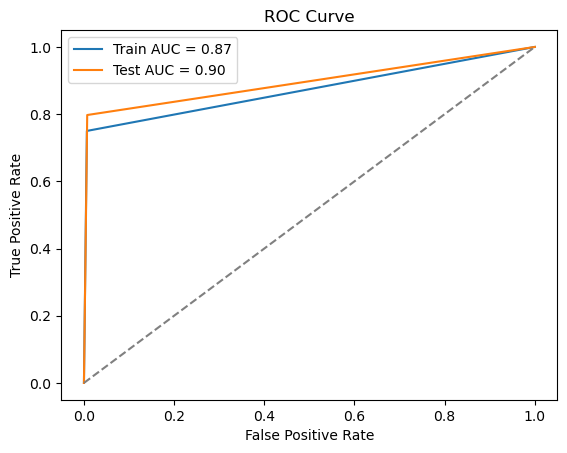

               Model Summary  Train Accuracy  Train Error Rate  Test Accuracy  \
0  XG Boost Model-- alpha 10        0.989433          0.010567       0.988187   

   Test Error Rate  5-Fold Cross-Validation Error  
0         0.011813                       0.013167  


In [ ]:
# use L1-penalized logistic regression at each node - use XGBoost to fit the model tree
# train the model for the APS data set without compensation for class imbalance

def xgboost(model_summary, train_df, test_df):
    # prep data by splitting x and y vars, binarize
    X_train, y_train, X_test, y_test = split_data(train_df, test_df)
    y_train = y_train.map({'neg': 0, 'pos': 1})
    y_test = y_test.map({'neg': 0, 'pos': 1})

    # determine α using cross-validation
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    cv_scores = []

    for alpha in alphas:
        model = xgb.XGBClassifier(
            booster='gblinear',
            objective='binary:logistic',
            reg_alpha=alpha,
            eval_metric='logloss',
            n_jobs=-1,
            random_state=13
        )
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append((alpha, np.mean(scores)))

    best_a = max(cv_scores, key=lambda x: x[1])[0]
    model_summary = model_summary + f"-- alpha {best_a}"
    print("Best alpha:", best_a)

    # train model with best alpha
    model = xgb.XGBClassifier(
        booster='gblinear',
        objective='binary:logistic',
        reg_alpha=best_a,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=13
    )
    
    # Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_error = 1 - np.mean(cv_acc)

    # fit and assess model
    model.fit(X_train, y_train)

    # assess model - Confusion Matrix, ROC, and AUC for training and test sets
    asessment_df = assess_model(model, model_summary, False, X_train, y_train, X_test, y_test)
    asessment_df["5-Fold Cross-Validation Error"] = cv_error

    print(asessment_df)
    return asessment_df

xgboost_model = xgboost("XG Boost Model", train_df, test_df)

### Use SMOTE to pre-process your data
Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

The uncompensated XG Boost tree overall performed better with an alpha of 10. We can see higer train and test accuracies with a lower cv error rate as well. However, because we have highly imbalanced data and SMOTE accounts for that, we can still see good results from the SMOTE XG Boost model. The key here is to look at the ROC curve. The SMOTE model has a higher, more curved ROC curve than the uncompensated model and will therefore result in better outcomes despite having slightly lower accuracy rates than the other model.The sharp, low ROC curve in the uncompensated model shows us that the model is biased towards the majority curve, so it is not learning the minority class well. This leads to an inflated overall accuracy, but weak minority class performance. <br>

Model Summary, Train Accuracy, Train Error Rate, Test Accuracy, Test Error Rate, 5-Fold Cross-Validation Error <br>
XG Boost Model-- alpha 10, 0.989433, 0.010567, 0.988187, 0.011813, 0.013167  <br>
XG Boost SMOTE-- alpha 10, 0.965975, 0.034025, 0.978000, 0.022000, 0.034127 <br>

Best alpha: 10
Train Confusion Matrix:
[[57693  1307]
 [ 2702 56298]]

Test Confusion Matrix:
[[15298   327]
 [   29   346]]


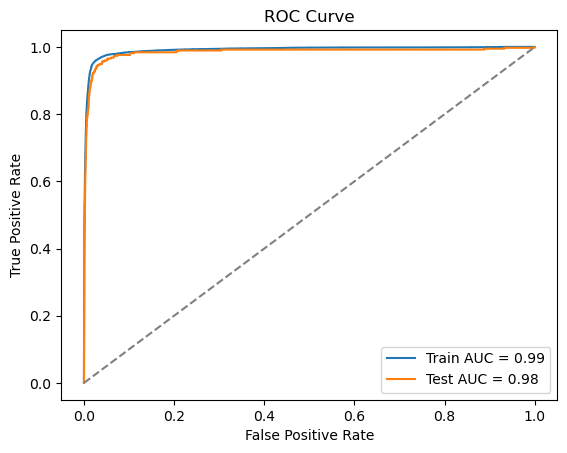

               Model Summary  Train Accuracy  Train Error Rate  Test Accuracy  \
0  XG Boost SMOTE-- alpha 10        0.966025          0.033975        0.97775   

   Test Error Rate  5-Fold Cross-Validation Error  
0          0.02225                       0.034144  


In [ ]:
# cross validation - SMOTE within folds
# use smote as part of a pipeline (imbalanded learn) gives us a more accurate cv score that is closer to test scores
# apply SMOTE to the training data to oversample the minority class
# train your XGBoost model on the SMOTE-resampled training data
# evaluate the model's performance on the corresponding validation fold (which remains unchanged)
# repeat for all folds and calculate averages

def xgboost_smote(model_summary, train_df, test_df):
    # prep data by splitting x and y vars, binarize
    X_train, y_train, X_test, y_test = split_data(train_df, test_df)
    y_train = y_train.map({'neg': 0, 'pos': 1})
    y_test = y_test.map({'neg': 0, 'pos': 1})

    # use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance
    # makes the minority class have similar amount of entries, as we can see in the train confusion matrix
    # only apply smote on train data
    smote = SMOTE(random_state=13)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # determine α using cross-validation
    alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    cv_scores = []

    for alpha in alphas:
        pipeline = Pipeline(steps=[
            ('smote', SMOTE(random_state=13)),
            ('xgb', XGBClassifier(
                booster='gblinear',
                objective='binary:logistic',
                reg_alpha=alpha,
                eval_metric='logloss',
                n_jobs=-1, # speeds up processing time by using all available CPUs
                random_state=13
            ))
        ])
        
        # used RepeatedStratifiedKFold because my best alpha kept changing as I reran the function
        # stabalizes best alpha and makes it less sensitive to randomness
        scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=13),
                                scoring='accuracy')
        cv_scores.append((alpha, np.mean(scores)))

    best_a = max(cv_scores, key=lambda x: x[1])[0]
    model_summary = model_summary + f"-- alpha {best_a}"
    print("Best alpha:", best_a)

    # define final model
    model = Pipeline(steps =[
            ('smote', SMOTE(random_state=13)),
            ('xgb', XGBClassifier(
                booster='gblinear',
                objective='binary:logistic',
                reg_alpha=best_a,
                eval_metric='logloss',
                random_state=13,
                n_jobs=-1
            ))
    ])

    # Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_acc = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
    cv_error = 1 - np.mean(cv_acc)

    # fit and assess final model
    model.fit(X_train_smote, y_train_smote)

    # assess model - Confusion Matrix, ROC, and AUC for training and test sets
    asessment_df = assess_model(model, model_summary, False, X_train_smote, y_train_smote, X_test, y_test)
    asessment_df["5-Fold Cross-Validation Error"] = cv_error

    print(asessment_df)

    return asessment_df

xgboost_smote_model = xgboost_smote("XG Boost SMOTE", train_df, test_df)

In [19]:
combined_xgboost_assessment_df = pd.concat([xgboost_model, xgboost_smote_model], axis=0)
print(combined_xgboost_assessment_df)

               Model Summary  Train Accuracy  Train Error Rate  Test Accuracy  \
0  XG Boost Model-- alpha 10        0.989433          0.010567       0.988187   
0  XG Boost SMOTE-- alpha 10        0.966025          0.033975       0.977750   

   Test Error Rate  5-Fold Cross-Validation Error  
0         0.011813                       0.013167  
0         0.022250                       0.034144  
